In [1]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
Setup complete  (16 CPUs, 15.2 GB RAM, 817.0/930.6 GB disk)


In [2]:
from ultralytics import YOLO
import pandas as pd
from IPython.display import display, Image
import shutil

import os
import re
import json
from pylabel import importer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pd.set_option('display.max_columns', None)


In [3]:
HOME = os.getcwd()
train_path = "../../data/material_version/train"
valid_path = "../../data/material_version/val"

train_annots = "../../data/material_version/instances_train_trashcan.json"
valid_annots = "../../data/material_version/instances_val_trashcan.json"

destination_path = f"{HOME}/destination"

results = "reports/results"

In [4]:
class ScriptUtilities:
    @staticmethod
    def json_viewer(annots_json):
        # Read the JSON file
        with open(annots_json, 'r') as file:
            annotations_data = json.load(file)

        # Display information for the top 5 images
        for image_info in annotations_data['images'][:5]:
            print(f"Image ID: {image_info['id']}")
            print(f"File Name: {image_info['file_name']}")
            print(f"Height: {image_info['height']}, Width: {image_info['width']}")
            print(f"Date Captured: {image_info['date_captured']}")
            print("----------------------")

        # View content under 'annotations' key
        if 'annotations' in annotations_data:
            print("Annotations:")
            for annotation in annotations_data['annotations'][:5]:
                print(annotation)
                print("----------------------")
        else:
            print("No 'annotations' key found in the JSON data.")

    @staticmethod
    def json_tree(annots_json):
        # Read the JSON file
        with open(annots_json, 'r') as file:
            annotations_data = json.load(file)
        # Print the keys at the top level of the JSON structure
        print(annotations_data.keys())

    @staticmethod
    def coco_to_yolo_converter(annots_json, path_to_images, name):
        dataset = importer.ImportCoco(annots_json, path_to_images=path_to_images, name=name)

        return dataset

In [5]:
# Train dataset
train_dataset = ScriptUtilities.coco_to_yolo_converter(train_annots, train_path, name="BCCD_train_coco")

# Valid dataset
valid_dataset = ScriptUtilities.coco_to_yolo_converter(valid_annots, valid_path, name="BCCD_valid_coco")

In [6]:
train_dataset.df.sample(5)


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,ann_bbox_xmax,ann_bbox_ymax,ann_bbox_width,ann_bbox_height,ann_area,ann_segmentation,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,,,,,,
142,../../data/material_version/train,vid_000260_frame0000040.jpg,,98,480,360,,,327.001961,140.001961,476.998039,318.998039,149.996078,178.996078,5932.005890,"[[476.0, 318.9980392156863, 476.9980392156863,...",0,,,,,1,rov,rov,,1
4068,../../data/material_version/train,vid_000148_frame0000043.jpg,,2508,480,360,,,3.001961,110.001961,148.998039,282.998039,145.996078,172.996078,22735.327466,"[[148.0, 282.9980392156863, 148.99803921568628...",0,,,,,11,trash_fishing_gear,trash_fishing_gear,,1
2427,../../data/material_version/train,vid_000086_frame0000025.jpg,,1495,480,270,,,389.001961,236.001961,480.998039,270.998039,91.996078,34.996078,830.229427,"[[480.0, 270.9980392156863, 480.9980392156863,...",0,,,,,1,rov,rov,,1
7048,../../data/material_version/train,vid_000112_frame0000035.jpg,,4343,480,360,,,318.002183,219.004545,354.995327,266.996429,36.993144,47.991883,970.543277,"[[346.0, 266.99642857142857, 351.0, 263.997076...",0,,,,,14,trash_plastic,trash_plastic,,1
4722,../../data/material_version/train,vid_000288_frame0000090.jpg,,2914,480,360,,,362.001969,253.041667,416.998024,310.980769,54.996055,57.939103,2046.275083,"[[391.0, 310.9807692307692, 396.0, 308.9951456...",0,,,,,12,trash_metal,trash_metal,,1


In [7]:
valid_dataset.df.sample(5)


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,ann_bbox_xmax,ann_bbox_ymax,ann_bbox_width,ann_bbox_height,ann_area,ann_segmentation,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,,,,,,
179,../../data/material_version/val,vid_000030_frame0000016.jpg,,6100,480,270,,,472.001961,213.001961,479.000000,261.998039,6.998039,48.996078,196.917651,"[[479.0, 261.9980392156863, 479.0, 213.0019607...",0,,,,,1,rov,rov,,1
1602,../../data/material_version/val,vid_000047_frame0000007.jpg,,6755,480,270,,,220.001961,46.001961,248.998016,59.998039,28.996055,13.996078,313.865848,"[[245.0, 59.998039215686276, 248.9976190476190...",0,,,,,14,trash_plastic,trash_plastic,,1
1914,../../data/material_version/val,vid_000172_frame0000018.jpg,,6889,480,360,,,149.001961,75.001961,447.998039,269.998039,298.996078,194.996078,38205.002949,"[[358.0, 269.9980392156863, 377.0, 266.9980392...",0,,,,,13,trash_paper,trash_paper,,1
1785,../../data/material_version/val,vid_000132_frame0000093.jpg,,6835,480,270,,,225.003676,188.002370,245.995935,205.997059,20.992258,17.994689,247.657974,"[[242.0, 205.99705882352941, 245.9959349593496...",0,,,,,5,animal_shells,animal_shells,,1
1302,../../data/material_version/val,vid_000152_frame0000008.jpg,,6622,480,360,,,259.004237,42.002591,321.989583,76.998039,62.985346,34.995449,961.157464,"[[301.0, 76.99803921568628, 319.0, 74.98888888...",0,,,,,3,animal_fish,animal_fish,,1


In [8]:
dataset_list = [train_dataset, valid_dataset]

for dataset in dataset_list:
    print("\n")
    print(f"Number of images: {dataset.analyze.num_images}")
    print(f"Number of classes: {dataset.analyze.num_classes}")
    print(f"Classes:{dataset.analyze.classes}")
    print(f"Class counts:\n{dataset.analyze.class_counts}")
    print(f"Path to annotations:\n{dataset.path_to_annotations}")



Number of images: 6008
Number of classes: 16
Classes:['rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab', 'animal_eel', 'animal_etc', 'trash_etc', 'trash_fabric', 'trash_fishing_gear', 'trash_metal', 'trash_paper', 'trash_plastic', 'trash_rubber', 'trash_wood']
Class counts:
cat_name
rov                   2653
trash_etc             1630
trash_plastic         1490
trash_metal            901
animal_fish            611
plant                  405
animal_starfish        274
trash_wood             271
animal_eel             267
trash_fabric           247
animal_crab            247
animal_etc             180
animal_shells          171
trash_paper            154
trash_fishing_gear     127
trash_rubber           113
Name: count, dtype: int64
Path to annotations:
..\..\data\material_version


Number of images: 1204
Number of classes: 16
Classes:['rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab', 'animal_eel', 'animal_etc', 'trash_etc

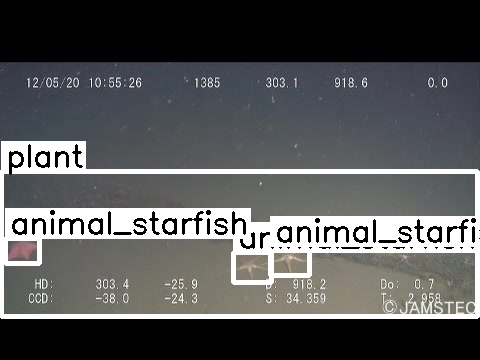

In [9]:
display(train_dataset.visualize.ShowBoundingBoxes(2))

In [10]:
train_dataset.export.ExportToYoloV5(output_path = f'{destination_path}/training/labels',
                              copy_images = True,
                              yaml_file = "dataset.yaml",
                              segmentation = True)

Exporting YOLO files...: 100%|██████████| 6008/6008 [01:37<00:00, 61.50it/s]


['c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\dataset.yaml',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000421_frame0000005.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000106_frame0000015.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000158_frame0000044.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000044_frame0000021.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000437_frame0000015.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000132_frame0000098.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\s

In [11]:
valid_dataset.export.ExportToYoloV5(output_path = f'{destination_path}/valid/labels',
                              copy_images = True,
                              yaml_file = "dataset.yaml",
                              segmentation = True)

Exporting YOLO files...: 100%|██████████| 1204/1204 [00:22<00:00, 52.94it/s]


['c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\dataset.yaml',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\labels\\vid_000342_frame0000228.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\labels\\vid_000142_frame0000034.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\labels\\vid_000039_frame0000001.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\labels\\vid_000234_frame0000001.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\labels\\vid_000074_frame0000052.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\valid\\labels\\vid_000153_frame0000013.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destinati

In [12]:
# Note!!! Only run this code once
path = f"destination/training/labels" #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

# Code adapted from: hhttps://www.kaggle.com/code/vencerlanz09/insect-images-classification-using-yolov5

In [13]:
# Note!!! Only run this code once
path = f"destination/valid/labels" #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

# Code adapted from: hhttps://www.kaggle.com/code/vencerlanz09/insect-images-classification-using-yolov5

In [14]:
os.environ["WANDB_MODE"]="offline"

In [15]:
!rm -f ../destination/training/labels.cache

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
import requests

url = "https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-seg.pt"
output_path = "yolov8n-seg.pt"

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(output_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


Downloaded yolov8n-seg.pt


In [17]:
# Load a model
model = YOLO(f"yolov8n-seg.pt")  # load a pretrained model (recommended for training)

In [18]:
# Train the model
results = model.train(data=f"destination/training/dataset.yaml", epochs=35, imgsz=(480, 270))

New https://pypi.org/project/ultralytics/8.3.41 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=destination/training/dataset.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=(480, 270), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

train: Scanning C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\labels.cache... 6008 images, 0 backgrounds, 193 corrupt: 100%|██████████| 6008/6008 [00:00<?, ?it/s]

train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000060.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-de


val: Scanning C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\labels.cache... 6008 images, 0 backgrounds, 193 corrupt: 100%|██████████| 6008/6008 [00:00<?, ?it/s]

train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000060.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-de

Plotting labels to runs\segment\train21\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 480 train, 480 val
Using 0 dataloader workers
Logging results to runs\segment\train21
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/35         0G      1.344      2.604      3.328       1.27         25        480: 100%|██████████| 364/364 [14:23<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:13<00:00,  1.39s/it]


                   all       5815       9323      0.467      0.228      0.196       0.13      0.465      0.227      0.191      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/35         0G      1.274      2.203      2.417      1.226         17        480: 100%|██████████| 364/364 [12:54<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:19<00:00,  1.43s/it]


                   all       5815       9323      0.505      0.362      0.342      0.225       0.51       0.36      0.339        0.2

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/35         0G      1.272      2.196      2.183      1.222         31        480: 100%|██████████| 364/364 [18:34<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:56<00:00,  1.63s/it]


                   all       5815       9323      0.579      0.401      0.396      0.259      0.574      0.395      0.385      0.225

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/35         0G      1.243      2.099       1.96      1.209         14        480: 100%|██████████| 364/364 [14:53<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:42<00:00,  1.55s/it]


                   all       5815       9323      0.566      0.405      0.445        0.3      0.568      0.407      0.444      0.262

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/35         0G        1.2      2.035      1.796      1.189         22        480: 100%|██████████| 364/364 [17:58<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:56<00:00,  1.30s/it]


                   all       5815       9323      0.633      0.514      0.549      0.348      0.628      0.506      0.534      0.301

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/35         0G       1.18      1.988      1.677      1.172         35        480: 100%|██████████| 364/364 [12:43<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:52<00:00,  1.28s/it]


                   all       5815       9323      0.617      0.567       0.59      0.397       0.62      0.557       0.58      0.346

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/35         0G      1.151      1.923      1.532      1.159         26        480: 100%|██████████| 364/364 [14:25<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:38<00:00,  1.53s/it]


                   all       5815       9323      0.666      0.585      0.643      0.428      0.683       0.56      0.629      0.368

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/35         0G      1.128      1.886      1.447      1.153         12        480: 100%|██████████| 364/364 [18:37<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:30<00:00,  1.49s/it]


                   all       5815       9323      0.727      0.617       0.69      0.479      0.721      0.601       0.67      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/35         0G      1.101      1.837      1.372      1.136         14        480: 100%|██████████| 364/364 [16:39<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:11<00:00,  1.38s/it]


                   all       5815       9323      0.741       0.67      0.724      0.499      0.731      0.656      0.702      0.416

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/35         0G      1.095      1.813      1.321      1.128         23        480: 100%|██████████| 364/364 [16:33<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [05:06<00:00,  1.68s/it]


                   all       5815       9323      0.771      0.679      0.746      0.523      0.756      0.668      0.725       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/35         0G      1.067      1.778      1.257      1.113         19        480: 100%|██████████| 364/364 [16:52<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:32<00:00,  1.50s/it]


                   all       5815       9323      0.796      0.667      0.755      0.531      0.793      0.657      0.742      0.457

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/35         0G      1.061      1.747      1.217      1.113         35        480: 100%|██████████| 364/364 [17:40<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:25<00:00,  1.46s/it]


                   all       5815       9323      0.795      0.702      0.783      0.543      0.779      0.691      0.763      0.465

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/35         0G      1.035      1.711       1.17      1.099         24        480: 100%|██████████| 364/364 [13:55<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:53<00:00,  1.61s/it]


                   all       5815       9323      0.769      0.711       0.76      0.534      0.759      0.702      0.745      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/35         0G      1.022      1.693       1.15      1.091         17        480: 100%|██████████| 364/364 [14:05<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:02<00:00,  1.33s/it]


                   all       5815       9323      0.767      0.742      0.803      0.562      0.769      0.725      0.789      0.476

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/35         0G      1.012      1.659      1.104      1.086         24        480: 100%|██████████| 364/364 [18:05<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:15<00:00,  1.40s/it]


                   all       5815       9323      0.816      0.753      0.817      0.583      0.806      0.751      0.803      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/35         0G     0.9952       1.64      1.073      1.075         25        480: 100%|██████████| 364/364 [15:28<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [05:27<00:00,  1.80s/it]


                   all       5815       9323      0.814      0.763      0.827      0.587      0.814      0.756      0.819      0.494

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/35         0G      0.997      1.635      1.039      1.076         25        480: 100%|██████████| 364/364 [13:58<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:33<00:00,  1.50s/it]


                   all       5815       9323      0.815      0.795      0.845      0.615      0.814      0.782      0.828      0.506

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/35         0G     0.9762      1.587      1.027      1.067         15        480: 100%|██████████| 364/364 [14:02<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:02<00:00,  1.33s/it]


                   all       5815       9323      0.841      0.781      0.849      0.617      0.836      0.771      0.834      0.514

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/35         0G      0.966      1.598     0.9953      1.063         26        480: 100%|██████████| 364/364 [16:31<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:36<00:00,  1.52s/it]


                   all       5815       9323      0.834      0.786      0.857      0.621       0.83       0.78      0.846      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/35         0G     0.9612      1.578     0.9773      1.061         29        480: 100%|██████████| 364/364 [16:59<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:12<00:00,  1.39s/it]


                   all       5815       9323      0.853      0.782      0.866      0.635      0.847      0.776       0.85      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/35         0G     0.9556      1.561     0.9607      1.058         14        480: 100%|██████████| 364/364 [16:31<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:41<00:00,  1.55s/it]


                   all       5815       9323      0.844      0.824      0.879      0.646      0.845      0.816      0.862      0.545

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/35         0G     0.9427      1.529     0.9366      1.051         22        480: 100%|██████████| 364/364 [13:49<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:53<00:00,  1.28s/it]

                   all       5815       9323      0.856      0.811      0.876      0.646      0.842      0.806      0.857      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/35         0G     0.9242      1.532     0.9177      1.046         24        480: 100%|██████████| 364/364 [17:03<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:23<00:00,  1.45s/it]


                   all       5815       9323      0.871      0.822      0.891      0.659      0.864      0.812       0.87      0.544

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/35         0G     0.9193      1.526     0.9018      1.042         15        480: 100%|██████████| 364/364 [18:55<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:37<00:00,  1.53s/it]


                   all       5815       9323      0.875      0.821      0.892      0.667      0.867      0.806      0.869      0.547

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/35         0G     0.9069      1.494     0.8748      1.033         28        480: 100%|██████████| 364/364 [17:21<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:38<00:00,  1.53s/it]


                   all       5815       9323      0.875      0.827      0.894      0.667      0.864      0.814      0.875      0.557
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/35         0G     0.8447      1.393     0.7391     0.9957          9        480: 100%|██████████| 364/364 [13:27<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:04<00:00,  1.34s/it]


                   all       5815       9323      0.873      0.831      0.899      0.669       0.87      0.816       0.88      0.559

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/35         0G     0.8373      1.368     0.7106     0.9915          9        480: 100%|██████████| 364/364 [13:26<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:57<00:00,  1.31s/it]


                   all       5815       9323      0.886      0.834      0.902      0.674      0.874      0.822      0.879      0.562

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/35         0G     0.8226      1.344     0.6869     0.9818          8        480: 100%|██████████| 364/364 [13:26<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:59<00:00,  1.32s/it]


                   all       5815       9323      0.874       0.85      0.906      0.683      0.877      0.827      0.886      0.567

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/35         0G     0.8079      1.335     0.6636      0.976         17        480: 100%|██████████| 364/364 [17:07<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:31<00:00,  1.49s/it]


                   all       5815       9323       0.89      0.848      0.913      0.691      0.883      0.836      0.894      0.575

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/35         0G     0.7978      1.313     0.6497     0.9727         11        480: 100%|██████████| 364/364 [13:28<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:55<00:00,  1.30s/it]


                   all       5815       9323      0.897      0.849      0.918      0.696      0.889      0.841      0.901      0.582

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/35         0G     0.7822      1.294     0.6268     0.9625         10        480: 100%|██████████| 364/364 [13:27<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:21<00:00,  1.44s/it]


                   all       5815       9323      0.898      0.856      0.924      0.706      0.884      0.851      0.907      0.586

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/35         0G     0.7707      1.292     0.6164     0.9622         14        480: 100%|██████████| 364/364 [13:31<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:00<00:00,  1.32s/it]


                   all       5815       9323      0.887      0.872      0.925      0.709      0.878      0.857      0.904      0.587

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/35         0G     0.7624      1.276     0.6077     0.9569         23        480: 100%|██████████| 364/364 [12:44<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:29<00:00,  1.15s/it]

                   all       5815       9323      0.895      0.864      0.925      0.712      0.886      0.853      0.903      0.589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/35         0G     0.7538       1.27     0.5921     0.9524          8        480: 100%|██████████| 364/364 [11:38<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:20<00:00,  1.10s/it]

                   all       5815       9323      0.886      0.877      0.927      0.716      0.878      0.867       0.91      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/35         0G     0.7484      1.256     0.5841     0.9498          9        480: 100%|██████████| 364/364 [12:16<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:30<00:00,  1.15s/it]

                   all       5815       9323      0.891      0.879      0.929       0.72      0.881      0.868      0.909      0.594



35 epochs completed in 11.422 hours.
Optimizer stripped from runs\segment\train21\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\train21\weights\best.pt, 6.8MB

Validating runs\segment\train21\weights\best.pt...
Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
YOLOv8n-seg summary (fused): 195 layers, 3,261,184 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:16<00:00,  1.08s/it]


                   all       5815       9323      0.891       0.88      0.928       0.72      0.881      0.869      0.909      0.594
                   rov       2136       2517      0.915      0.886      0.949      0.861      0.915      0.886      0.948      0.751
                 plant        371        392      0.951      0.906      0.962      0.688      0.933      0.888      0.928      0.541
           animal_fish        528        595      0.967      0.879      0.958      0.817      0.963      0.876      0.955      0.725
       animal_starfish         74        190      0.588      0.863      0.822      0.496      0.554      0.811      0.738      0.254
         animal_shells         99        171      0.889      0.658      0.829       0.53      0.865       0.64      0.785      0.411
           animal_crab        145        245      0.799       0.89      0.904      0.651      0.803      0.894      0.902      0.496
            animal_eel        184        266      0.884      0.823   

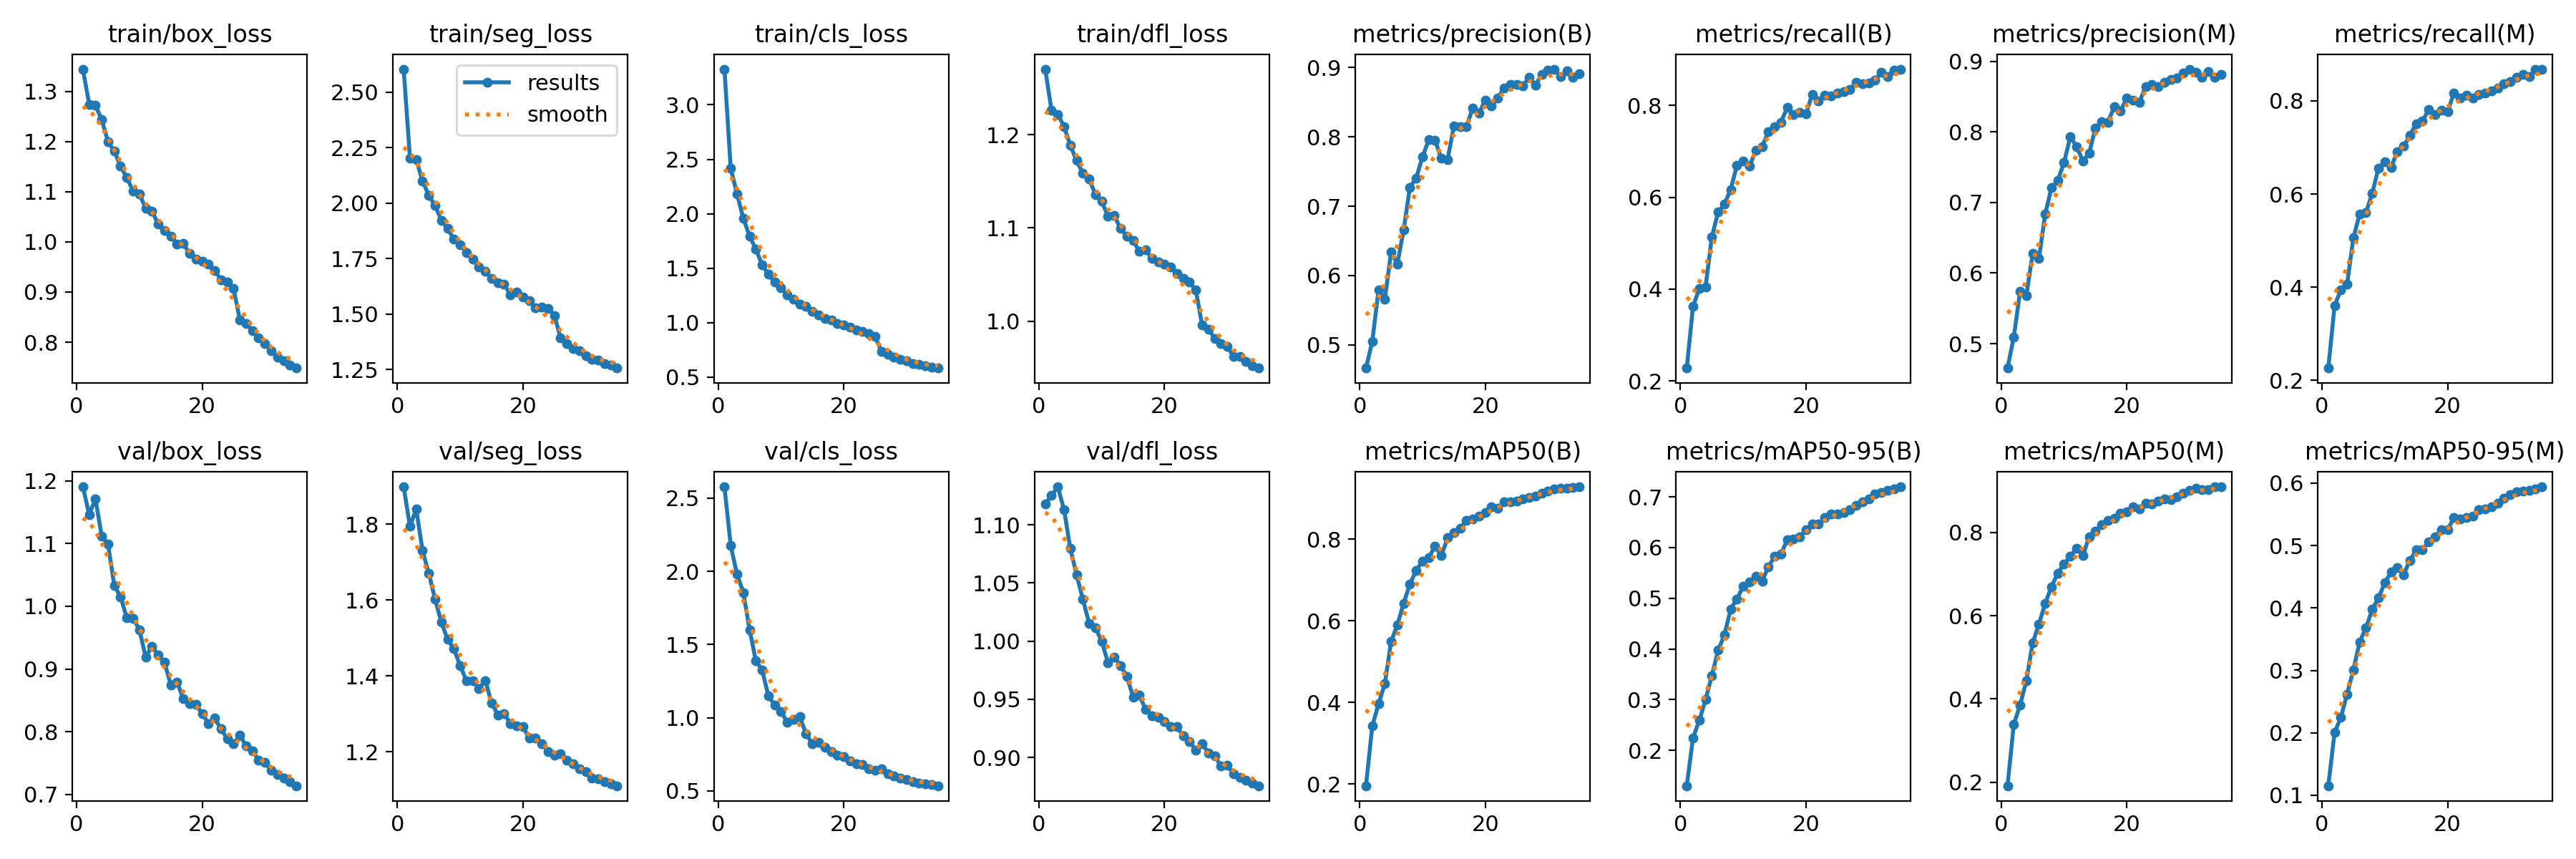

In [22]:
# Path to the PNG file
result_png_path = "../models/runs/segment/train21/results.png"

# Display the PNG file
Image(result_png_path)


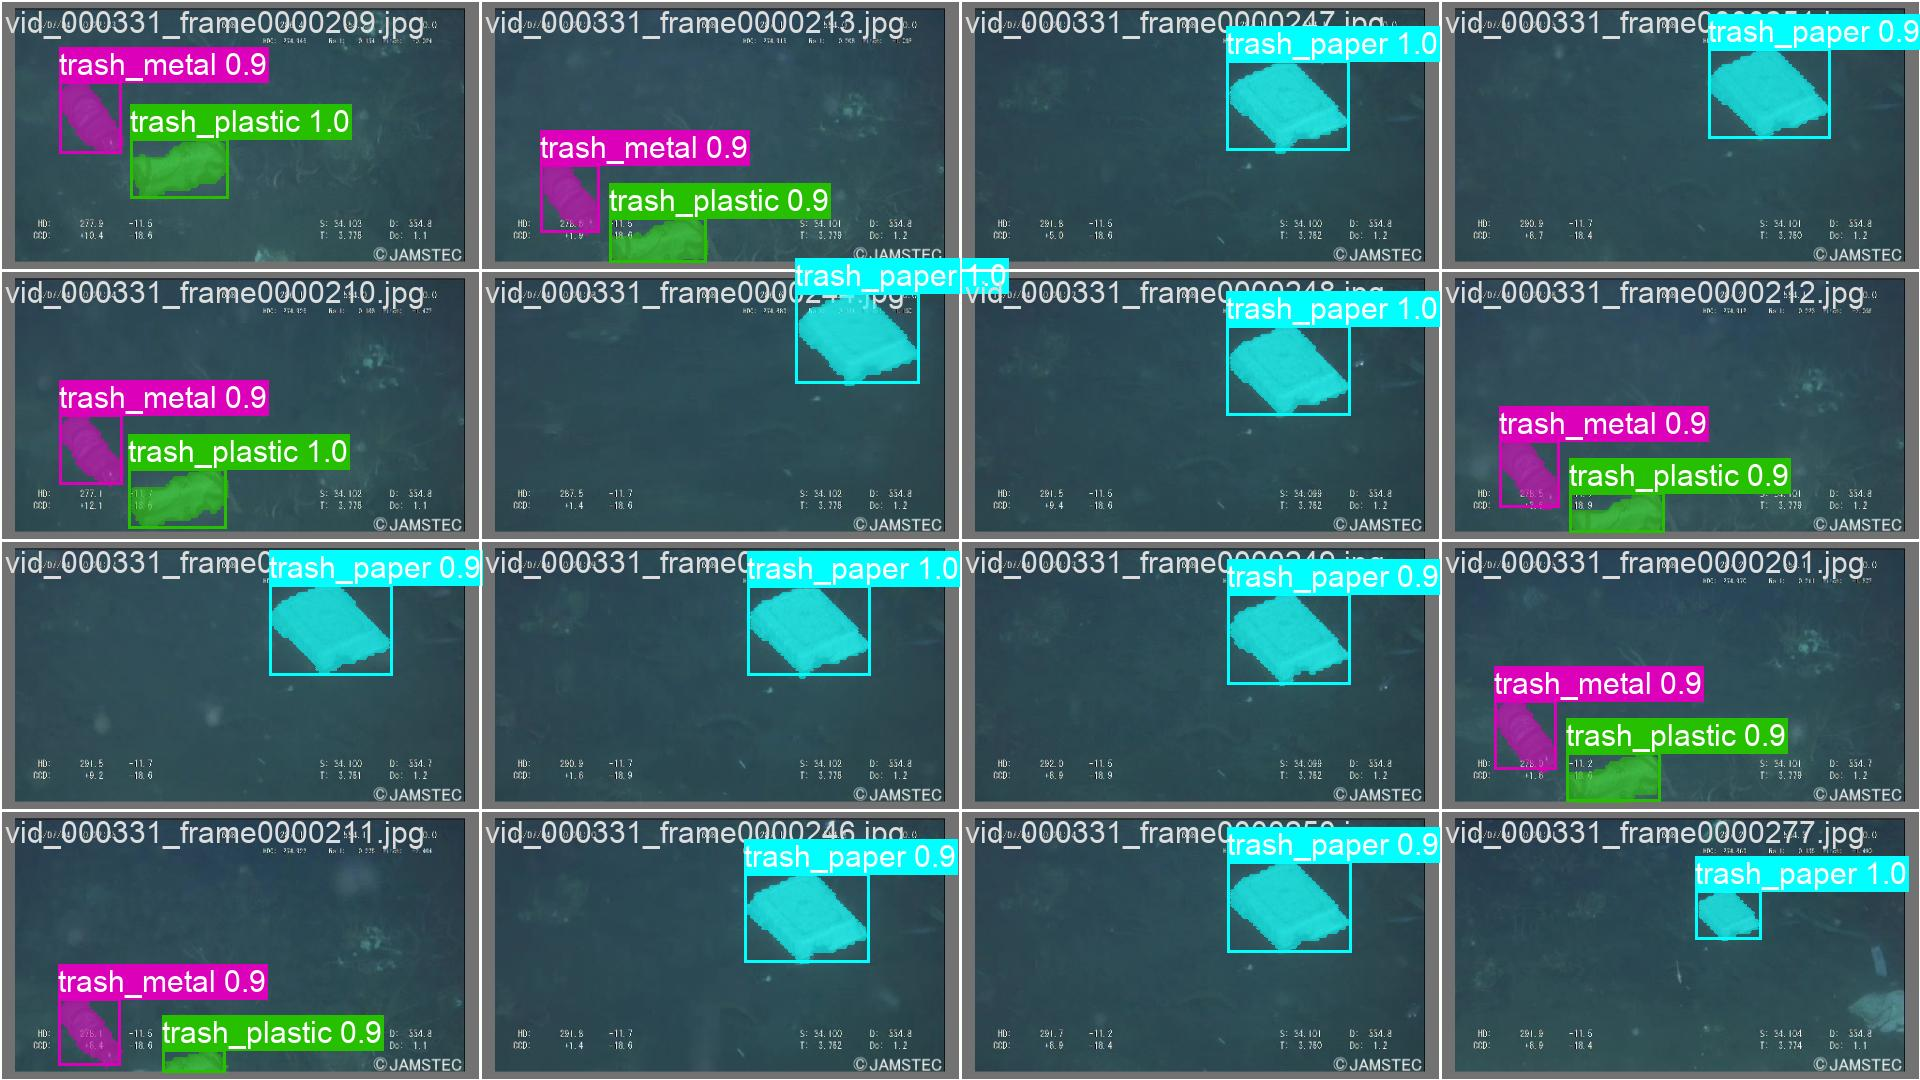

In [24]:
# Path to the PNG file
result_png_path = f"{HOME}/runs/segment/train21/val_batch1_pred.jpg"

# Display the PNG file
Image(result_png_path)

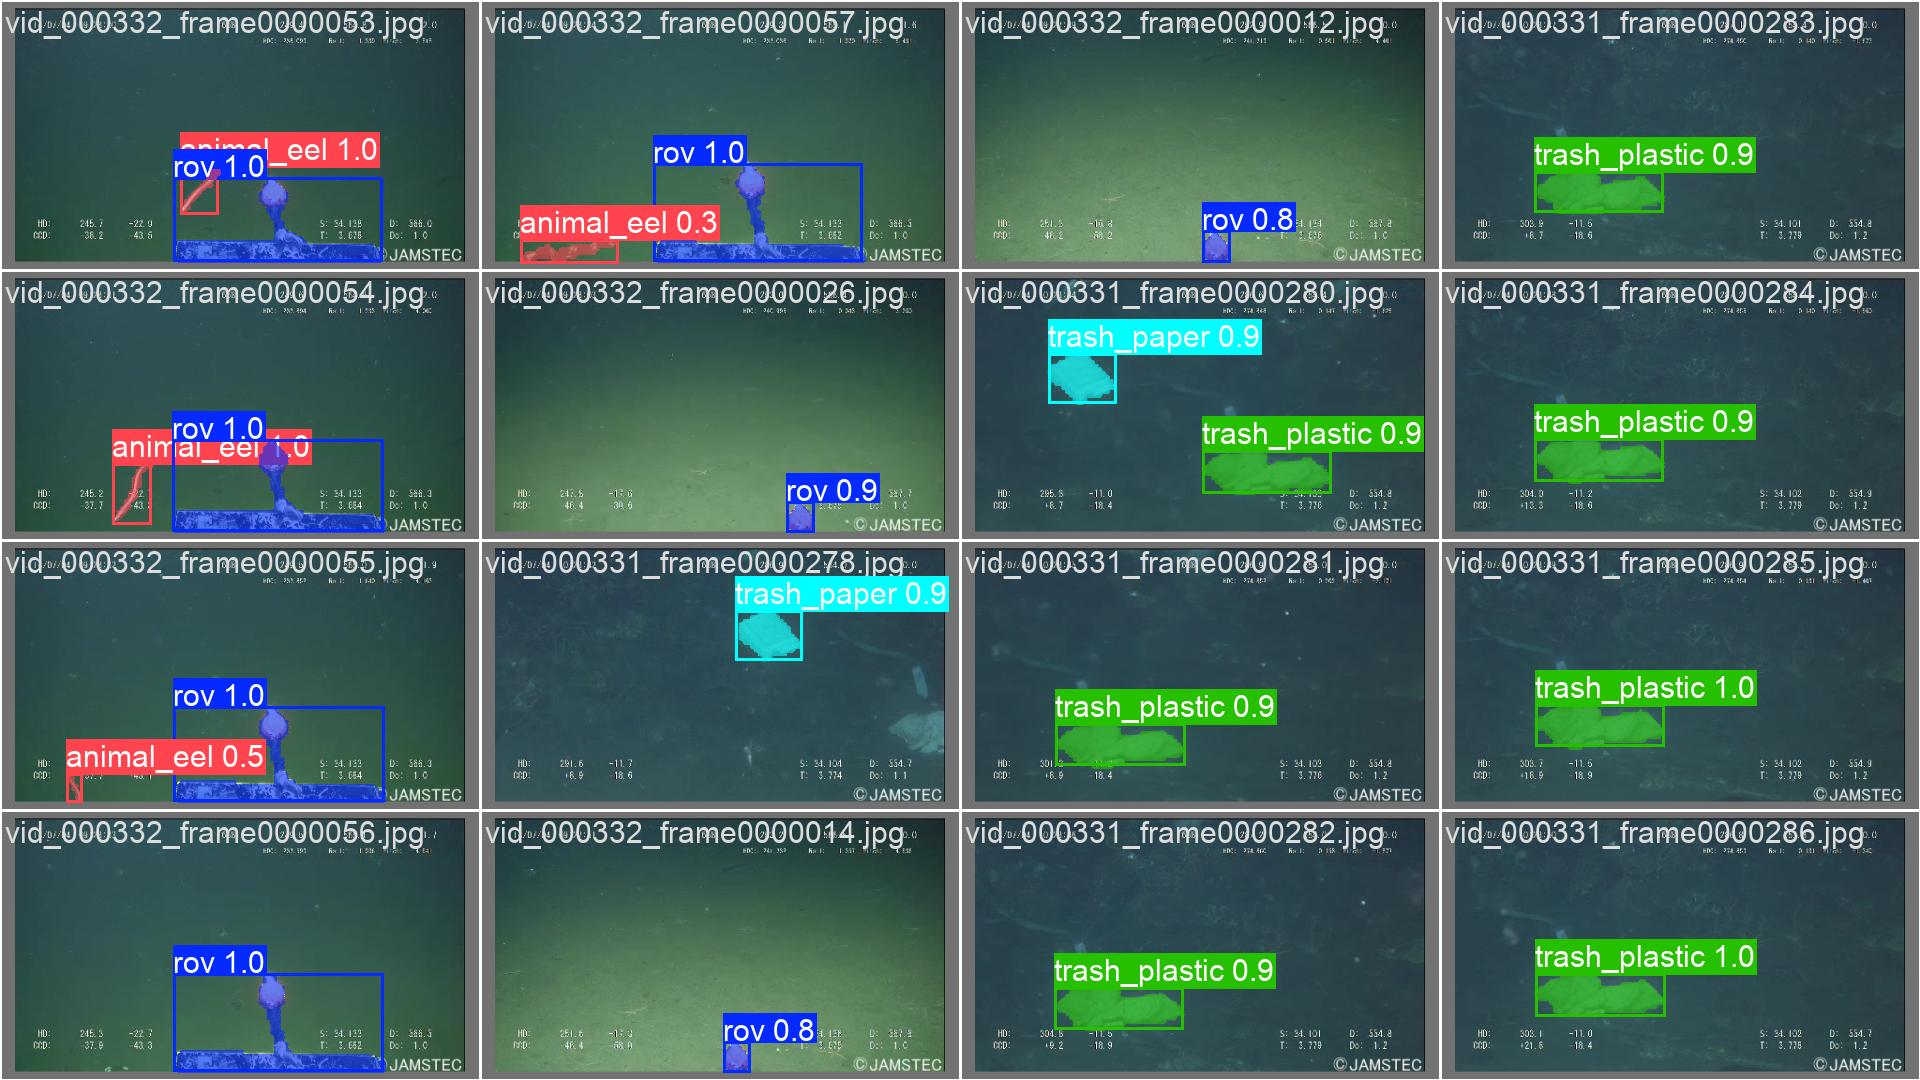

In [25]:
# Path to the PNG file
result_png_path = f"{HOME}/runs/segment/train21/val_batch2_pred.jpg"

# Display the PNG file
Image(result_png_path)

In [60]:
test_image = '../../data/material_version/val/vid_000212_frame0000009.jpg'

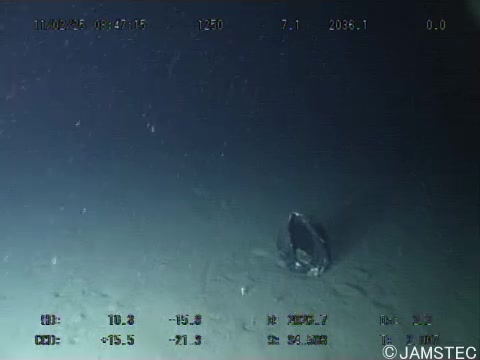

In [61]:
Image(test_image)

In [62]:
test_r = model(test_image)


image 1/1 c:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\..\..\data\material_version\val\vid_000212_frame0000009.jpg: 384x480 1 trash_etc, 42.1ms
Speed: 1.0ms preprocess, 42.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 480)


In [63]:
test_r[0].show()

NameError: name 'model' is not defined